In [37]:
import os
import sys

problems_path = os.path.abspath(os.path.join('test_problems'))
solver_path = os.path.abspath(os.path.join('../solvers'))
fig_path = os.path.abspath(os.path.join('./figs'))
data_path = os.path.abspath(os.path.join('./data'))
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
if problems_path not in sys.path:
    sys.path.append(problems_path)
if solver_path not in sys.path:
    sys.path.append(solver_path)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

rc('text', usetex=True)

In [39]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
from problems import JOS1, JOS1_L1, SD, FDS, FDS_CONSTRAINED
from zfista import minimize_proximal_gradient

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [40]:
def generate_start_points(low, high, n_dims, n_samples=1000):
    return [np.random.uniform(low=low, high=high, size=n_dims) for _ in
            range(n_samples)]


def run(problem, start_points, tol=1e-5, nesterov=False,
        nesterov_ratio=(0, 0.25), n_jobs=-1, verbose=False):
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(minimize_proximal_gradient)(problem.f, problem.g,
                                            problem.jac_f, problem.prox_wsum_g,
                                            x0,
                                            tol=tol, nesterov=nesterov,
                                            nesterov_ratio=nesterov_ratio,
                                            return_all=True, verbose=verbose)
        for x0 in start_points)
    return results


def show_Pareto_front(problem, results, results_nesterov, step=None, s=15,
                      alpha=0.75, fname=None, elev=15, azim=130, linewidths=.1):
    labels = ["Starting points", f"PGM ($k={step}$)", f"Acc-PGM ($k={step}$)",
              "PGM (Solutions)", "Acc-PGM (Solutions)"]
    fig = plt.figure(figsize=(7.5, 7.5), dpi=100)
    if problem.m_dims == 2:
        ax = fig.add_subplot(111)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    if problem.m_dims == 3:
        ax = fig.add_subplot(111, projection='3d', clip_on=True)
        ax.view_init(elev=elev, azim=azim)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=0.6)
    for i, (result, result_acc) in tqdm(
            enumerate(zip(results, results_nesterov))):
        allvecs = result.allvecs
        allvecs_acc = result_acc.allvecs
        x0 = allvecs[0]
        F_of_x0 = problem.f(x0) + problem.g(x0)
        if step is not None:
            xk = allvecs[step]
            xk_acc = allvecs_acc[step]
            F_of_xk = problem.f(xk) + problem.g(xk)
            F_of_xk_acc = problem.f(xk_acc) + problem.g(xk_acc)
        F_pareto = result.fun
        F_pareto_acc = result_acc.fun
        if problem.m_dims == 2:
            ax.scatter(*F_of_x0, color="#8e44ad", marker="x", label=labels[0], s=s, alpha=alpha, linewidths=linewidths)
            if step is not None:
                ax.scatter(*F_of_xk, color="#2980b9",
                       marker="<", label=labels[1], s=s, alpha=alpha, linewidths=linewidths)
                ax.scatter(*F_of_xk_acc, facecolors='none', edgecolor="#e74c3c", marker="*",
                       label=labels[2], s=s, alpha=alpha, linewidths=linewidths)
        ax.scatter(*F_pareto, color="#2980b9",
                   marker=".", label=labels[3], s=s, alpha=alpha, linewidths=linewidths)
        ax.scatter(*F_pareto_acc, facecolors='none', edgecolors="#e74c3c", marker="D",
                   label=labels[4], s=s, alpha=alpha, linewidths=linewidths)
    ax.set_xlabel(r'$F_1$', fontsize=15)
    ax.set_ylabel(r'$F_2$', fontsize=15)
    if problem.m_dims == 3:
        ax.set_zlabel(r'$F_3$', fontsize=15)
        ax.legend(labels[-2:], bbox_transform=ax.transData)
    elif step is None:
        ax.legend([labels[0]] + labels[-2:])
    else:
        ax.legend(labels)
    if fname is not None:
        plt.savefig(fig_path + '/' + fname, bbox_inches='tight')


def get_stats(results):
    nits = [result.nit for result in results]
    nit_internals = [result.nit_internal for result in results]
    execution_times = [result.execution_time for result in results]
    stats = {'nit': {'mean': np.mean(nits), 'std': np.std(nits),
                     'max': np.max(nits)},
             'nit_internal': {'mean': np.mean(nit_internals),
                              'std': np.std(nit_internals),
                              'max': np.max(nit_internals)},
             'execusion_time': {'mean': np.mean(execution_times),
                                'std': np.std(execution_times),
                                'max': np.max(execution_times)}}
    return stats

## JOS1
Minimize
$$
f_1(x) = \frac{1}{n} \| x \|_2^2, \quad f_2(x) = \frac{1}{n} \| x - 2\|_2^2
$$
subject to $x \in \mathbf{R^n}$.

In [5]:
n_dims = 50
problem_JOS1 = JOS1(n_dims=n_dims)
start_points_JOS1 = generate_start_points(low=-2, high=4, n_dims=n_dims)

CPU times: user 4.91 ms, sys: 1.74 ms, total: 6.65 ms
Wall time: 5.64 ms


### Proximal Gradient Method

In [6]:
results_JOS1 = run(problem_JOS1, start_points_JOS1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.0s
/Users/zalgo/.anyenv/envs/pyenv/versions/3.9.9/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.5min
/Users/zalgo/.anyenv/envs/pyenv/versions/3.9.9/lib/python3.9/site-packages/scipy/optimize/_hessian_

CPU times: user 4.05 s, sys: 584 ms, total: 4.63 s
Wall time: 21min 59s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 22.0min finished


### Accelerated Proximal Gradient Method

In [7]:
results_acc_JOS1 = run(problem_JOS1, start_points_JOS1, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

CPU times: user 2.12 s, sys: 321 ms, total: 2.44 s
Wall time: 5min 57s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.0min finished


### Complexity

In [8]:
import pprint

stats_JOS1 = {'PGM': get_stats(results_JOS1), 'Acc-PGM': get_stats(results_acc_JOS1)}
pprint.pprint(stats_JOS1)

{'Acc-PGM': {'execusion_time': {'max': 4.11248517036438,
                                'mean': 2.837328394174576,
                                'std': 0.3453078685479257},
             'nit': {'max': 65, 'mean': 65.0, 'std': 65.0},
             'nit_internal': {'max': 1495,
                              'mean': 1092.774,
                              'std': 88.35859281360246}},
 'PGM': {'execusion_time': {'max': 19.9957058429718,
                            'mean': 10.511403178691864,
                            'std': 1.512655924934079},
         'nit': {'max': 238, 'mean': 232.001, 'std': 232.001},
         'nit_internal': {'max': 5474,
                          'mean': 3900.979,
                          'std': 328.6646749484952}}}


0it [00:00, ?it/s]

CPU times: user 55.9 s, sys: 1.1 s, total: 57 s
Wall time: 57.5 s


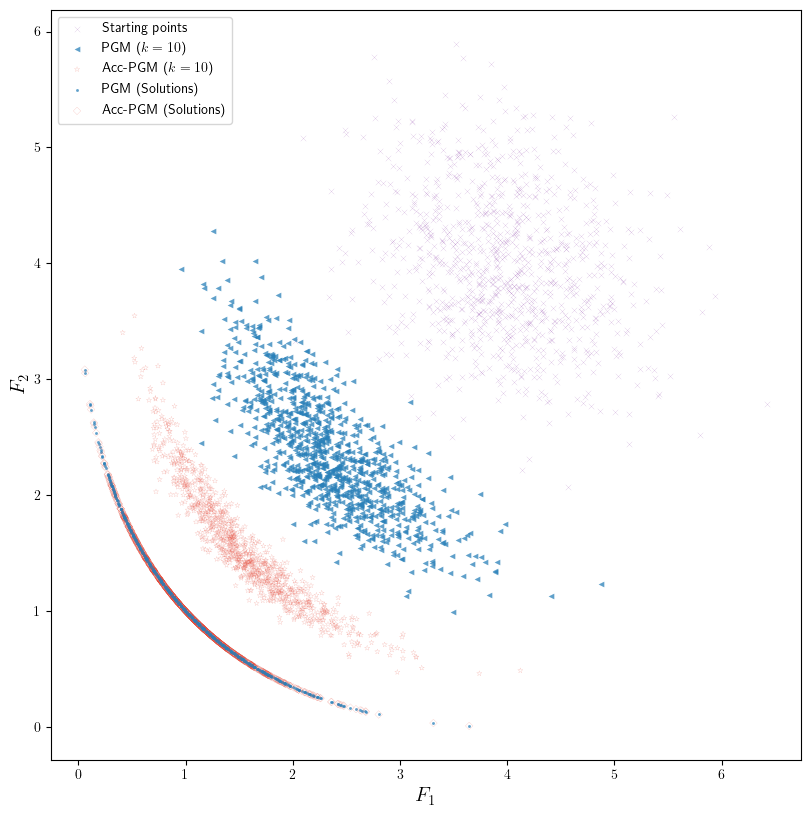

In [9]:
show_Pareto_front(problem_JOS1, results_JOS1, results_acc_JOS1, step=10, fname='JOS1.pdf')

### Accelerated Proximal Gradient Method (over relaxation) 

In [10]:
results_acc_overrelax_JOS1 = run(problem_JOS1, start_points_JOS1, nesterov=True,
                            nesterov_ratio=(0.25, 0.25))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

CPU times: user 1.89 s, sys: 297 ms, total: 2.19 s
Wall time: 4min 28s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.5min finished


### Complexity

In [11]:
stats_overrelax_JOS1 = {'PGM': get_stats(results_JOS1),
         'Acc-PGM (over relax)': get_stats(results_acc_overrelax_JOS1)}
pprint.pprint(stats_overrelax_JOS1)

{'Acc-PGM (over relax)': {'execusion_time': {'max': 3.4478209018707275,
                                             'mean': 2.128529145002365,
                                             'std': 0.3028869354274636},
                          'nit': {'max': 51, 'mean': 51.0, 'std': 51.0},
                          'nit_internal': {'max': 1173,
                                           'mean': 856.915,
                                           'std': 69.15650204427637}},
 'PGM': {'execusion_time': {'max': 19.9957058429718,
                            'mean': 10.511403178691864,
                            'std': 1.512655924934079},
         'nit': {'max': 238, 'mean': 232.001, 'std': 232.001},
         'nit_internal': {'max': 5474,
                          'mean': 3900.979,
                          'std': 328.6646749484952}}}


0it [00:00, ?it/s]

CPU times: user 41.8 s, sys: 752 ms, total: 42.5 s
Wall time: 42.9 s


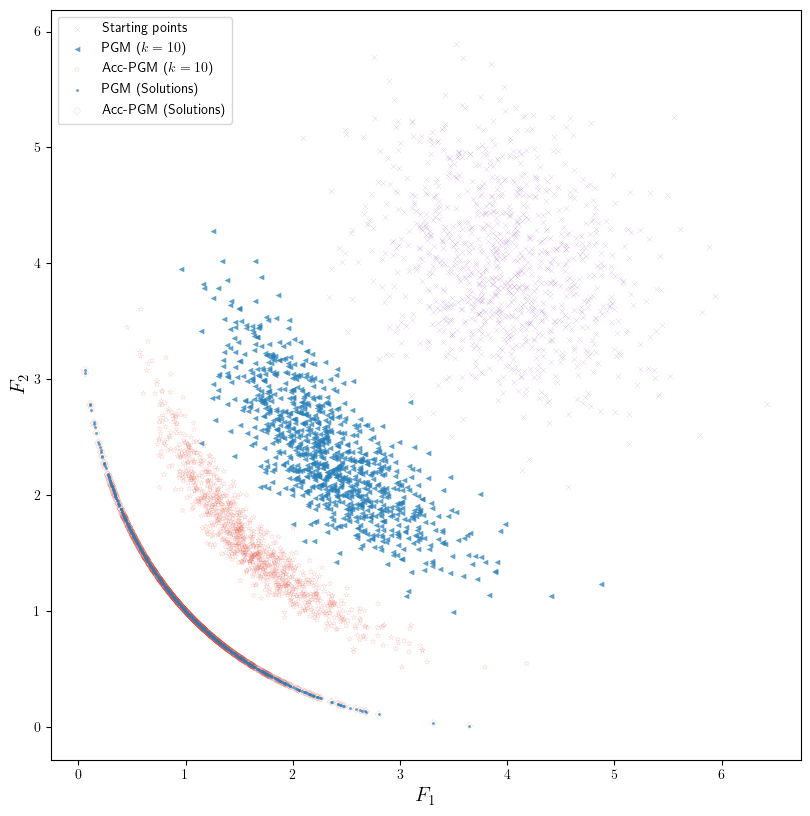

In [12]:
show_Pareto_front(problem_JOS1, results_JOS1, results_acc_overrelax_JOS1, step=10)

## JOS1 + $\ell_1$ penalty
Minimize
$$
F_1(x) = \frac{1}{n} \| x \|_2^2 + \frac{1}{n} \|x\|_1, \quad F_2(x) = \frac{1}{n} \| x - 2\|_2^2 + \frac{1}{2n} \|x - 1\|_1
$$
subject to $x \in \mathbf{R}^n$.

In [13]:
n_dims = 50
problem_JOS1_L1 = JOS1_L1(n_dims=n_dims, l1_ratios=(1 / n_dims, 1 / n_dims / 2))
start_points_JOS1_L1 = generate_start_points(low=-2, high=4, n_dims=n_dims)

CPU times: user 6.81 ms, sys: 2.66 ms, total: 9.47 ms
Wall time: 7.62 ms


### Proximal Gradient Method

In [14]:
results_JOS1_L1 = run(problem_JOS1_L1, start_points_JOS1_L1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3

CPU times: user 3.72 s, sys: 472 ms, total: 4.19 s
Wall time: 20min 43s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 20.7min finished


### Accelerated Proximal Gradient Method

In [15]:
results_acc_JOS1_L1 = run(problem_JOS1_L1, start_points_JOS1_L1, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

CPU times: user 3.11 s, sys: 418 ms, total: 3.53 s
Wall time: 15min 9s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 15.2min finished


### Complexity

In [16]:
stats_JOS1_L1 = {'PGM': get_stats(results_JOS1_L1), 'Acc-PGM': get_stats(results_acc_JOS1_L1)}
pprint.pprint(stats_JOS1_L1)

{'Acc-PGM': {'execusion_time': {'max': 18.161266088485718,
                                'mean': 7.2379501166343685,
                                'std': 1.441155378196316},
             'nit': {'max': 187, 'mean': 161.224, 'std': 161.224},
             'nit_internal': {'max': 7604,
                              'mean': 2779.011,
                              'std': 480.79760282160305}},
 'PGM': {'execusion_time': {'max': 19.746050119400024,
                            'mean': 9.903664604902268,
                            'std': 1.8566058023046286},
         'nit': {'max': 229, 'mean': 218.999, 'std': 218.999},
         'nit_internal': {'max': 8372,
                          'mean': 3779.528,
                          'std': 556.0926426558798}}}


0it [00:00, ?it/s]

CPU times: user 55.9 s, sys: 947 ms, total: 56.8 s
Wall time: 56.7 s


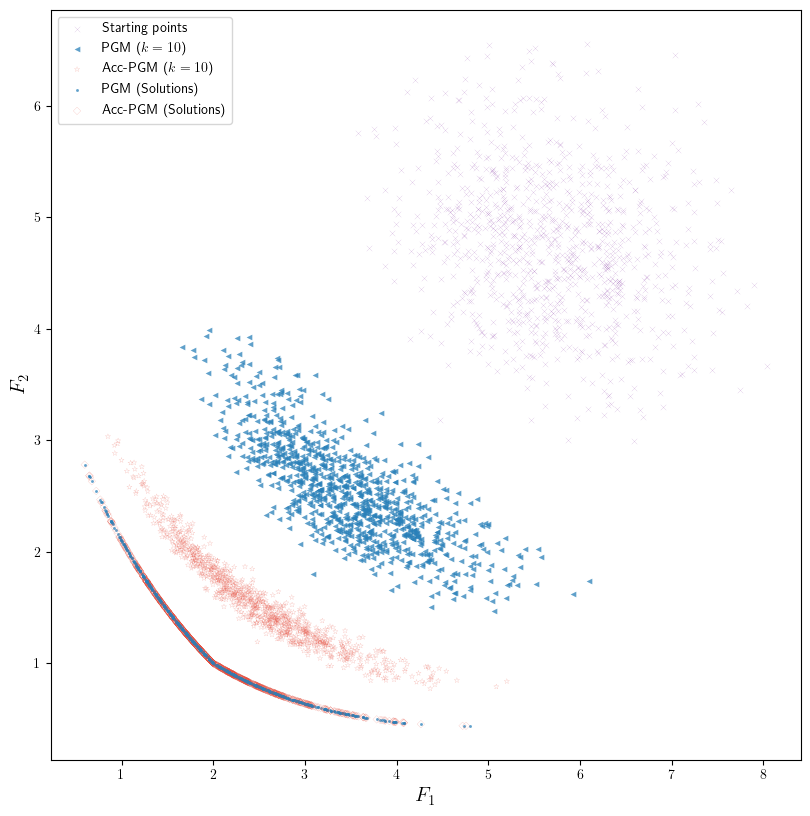

In [17]:
show_Pareto_front(problem_JOS1_L1, results_JOS1_L1, results_acc_JOS1_L1, step=10, fname='JOS1_L1.pdf')

### Accelerated Proximal Gradient Method (over relaxation) 

In [18]:
results_acc_overrelax_JOS1_L1 = run(problem_JOS1_L1, start_points_JOS1_L1, nesterov=True,
                  nesterov_ratio=(0.25, 0.25))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

CPU times: user 2.86 s, sys: 394 ms, total: 3.25 s
Wall time: 13min 2s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 13.0min finished


### Complexity

In [19]:
stats_overrelax_JOS1_L1 = {'PGM': get_stats(results_JOS1_L1),
         'Acc-PGM (over relax)': get_stats(results_acc_overrelax_JOS1_L1)}
pprint.pprint(stats_overrelax_JOS1_L1)

{'Acc-PGM (over relax)': {'execusion_time': {'max': 13.742324113845825,
                                             'mean': 6.2233141345977785,
                                             'std': 1.3554142575165107},
                          'nit': {'max': 170, 'mean': 140.013, 'std': 140.013},
                          'nit_internal': {'max': 5852,
                                           'mean': 2418.145,
                                           'std': 438.49942756519084}},
 'PGM': {'execusion_time': {'max': 19.746050119400024,
                            'mean': 9.903664604902268,
                            'std': 1.8566058023046286},
         'nit': {'max': 229, 'mean': 218.999, 'std': 218.999},
         'nit_internal': {'max': 8372,
                          'mean': 3779.528,
                          'std': 556.0926426558798}}}


0it [00:00, ?it/s]

CPU times: user 42.1 s, sys: 708 ms, total: 42.8 s
Wall time: 43.2 s


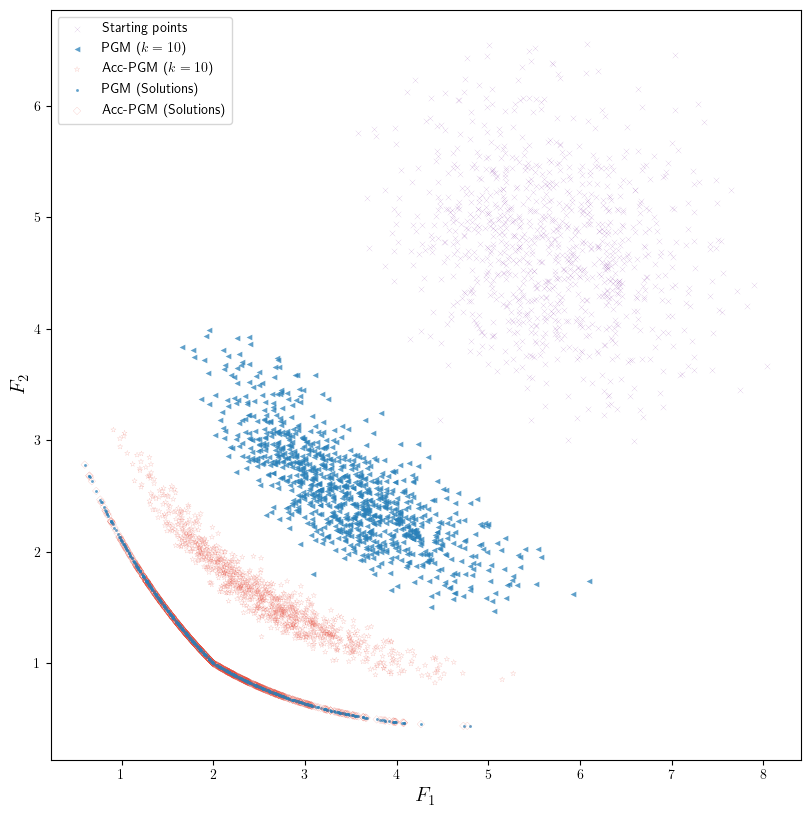

In [20]:
show_Pareto_front(problem_JOS1_L1, results_JOS1_L1, results_acc_overrelax_JOS1_L1, step=10)

## SD
Minimize
$$F_1(x) = 2 x_1 + \sqrt{2} x_2 + \sqrt{2} x_3 + x_4, \quad F_2(x) = \frac{2}{x_1} + \frac{2 \sqrt{2}}{x_2} + \frac{2 \sqrt{2}}{x_3} + \frac{2}{x_4}$$
subject to $(1, \sqrt{2}, \sqrt{2}, 1)^\top \le x \le (3, 3, 3, 3)^\top$.

In [21]:
problem_SD = SD()
start_points_SD = generate_start_points(low=problem_SD.lb, high=problem_SD.ub,
                                     n_dims=problem_SD.n_dims)

CPU times: user 17.5 ms, sys: 5.23 ms, total: 22.7 ms
Wall time: 18.9 ms


### Proximal Gradient Method

In [22]:
results_SD = run(problem_SD, start_points_SD)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

CPU times: user 1.83 s, sys: 264 ms, total: 2.09 s
Wall time: 5min 53s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.9min finished


### Accelerated Proximal Gradient Method

In [23]:
results_acc_SD = run(problem_SD, start_points_SD, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1

CPU times: user 1.85 s, sys: 270 ms, total: 2.12 s
Wall time: 5min 45s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.8min finished


### Complexity

In [24]:
stats_SD = {'PGM': get_stats(results_SD), 'Acc-PGM': get_stats(results_acc_SD)}
pprint.pprint(stats_SD)

{'Acc-PGM': {'execusion_time': {'max': 3.983208179473877,
                                'mean': 2.7447627878189085,
                                'std': 0.4405145075597727},
             'nit': {'max': 57, 'mean': 37.645, 'std': 37.645},
             'nit_internal': {'max': 1026,
                              'mean': 700.74,
                              'std': 118.32680338790531}},
 'PGM': {'execusion_time': {'max': 5.202019214630127,
                            'mean': 2.8074752533435823,
                            'std': 0.6009744670669542},
         'nit': {'max': 73, 'mean': 39.962, 'std': 39.962},
         'nit_internal': {'max': 1371,
                          'mean': 742.861,
                          'std': 166.46116567836475}}}


0it [00:00, ?it/s]

CPU times: user 27.4 s, sys: 448 ms, total: 27.9 s
Wall time: 27.4 s


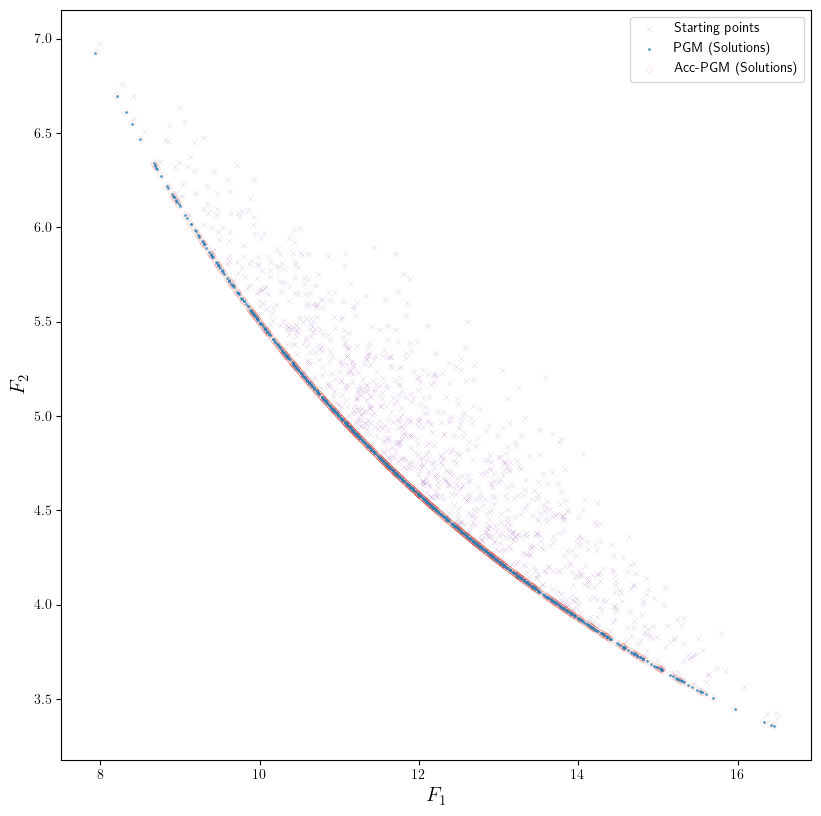

In [25]:
%matplotlib inline
show_Pareto_front(problem_SD, results_SD, results_acc_SD, fname='SD.pdf')

### Accelerated Proximal Gradient Method (over relaxation) 

In [26]:
results_acc_overrelax_SD = run(problem_SD, start_points_SD, nesterov=True,
                  nesterov_ratio=(0.25, 0.25))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

CPU times: user 1.8 s, sys: 247 ms, total: 2.05 s
Wall time: 5min 15s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.3min finished


### Complexity

In [27]:
stats_overrelax_SD = {'PGM': get_stats(results_SD),
         'Acc-PGM (over relax)': get_stats(results_acc_overrelax_SD)}
pprint.pprint(stats_overrelax_SD)

{'Acc-PGM (over relax)': {'execusion_time': {'max': 3.975285053253174,
                                             'mean': 2.5065483906269073,
                                             'std': 0.4240966512625004},
                          'nit': {'max': 55, 'mean': 35.242, 'std': 35.242},
                          'nit_internal': {'max': 1045,
                                           'mean': 655.863,
                                           'std': 111.53681110288208}},
 'PGM': {'execusion_time': {'max': 5.202019214630127,
                            'mean': 2.8074752533435823,
                            'std': 0.6009744670669542},
         'nit': {'max': 73, 'mean': 39.962, 'std': 39.962},
         'nit_internal': {'max': 1371,
                          'mean': 742.861,
                          'std': 166.46116567836475}}}


0it [00:00, ?it/s]

CPU times: user 16.1 s, sys: 227 ms, total: 16.4 s
Wall time: 16.5 s


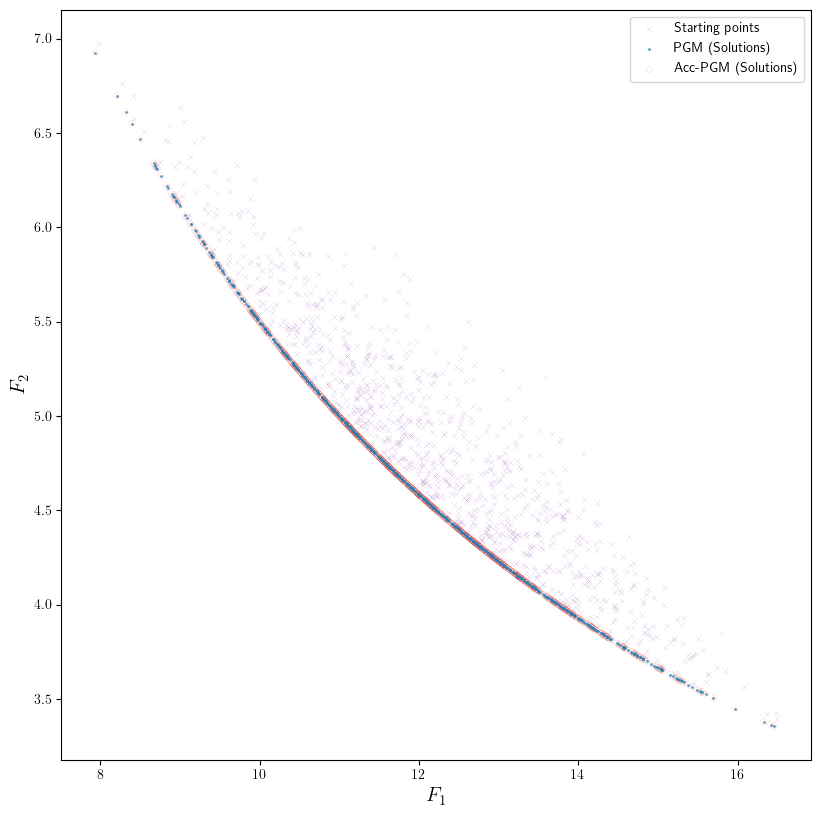

In [28]:
show_Pareto_front(problem_SD, results_SD, results_acc_overrelax_SD)

## FDS
Minimize
$$F_1(x) = \frac{1}{n^2} \sum_{i = 1}^n i (x_i - i)^4, \quad F_2(x) = \exp \left( \sum_{i = 1}^n \frac{x_i}{n} \right) + \|x\|_2^2, \quad F_3(x) = \frac{1}{n(n + 1)} \sum_{i = 1}^n i (n - i + 1) \exp (- x_i)$$
subject to $x \in \mathbf{R}^n$.

In [29]:
n_dims = 10
problem_FDS = FDS(n_dims=n_dims)
start_points_FDS = generate_start_points(low=-2, high=2, n_dims=n_dims)

CPU times: user 5.65 ms, sys: 1.98 ms, total: 7.64 ms
Wall time: 6.21 ms


### Proximal Gradient Method

In [30]:
results_FDS = run(problem_FDS, start_points_FDS)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31

CPU times: user 8.05 s, sys: 825 ms, total: 8.87 s
Wall time: 2h 46min 3s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 166.1min finished


### Accelerated Proximal Gradient Method

In [31]:
results_acc_FDS = run(problem_FDS, start_points_FDS, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11

CPU times: user 3.88 s, sys: 464 ms, total: 4.35 s
Wall time: 1h 1min 11s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 61.2min finished


### Complexity

In [32]:
stats_FDS = {'PGM': get_stats(results_FDS), 'Acc-PGM': get_stats(results_acc_FDS)}
pprint.pprint(stats_FDS)

{'Acc-PGM': {'execusion_time': {'max': 59.558045864105225,
                                'mean': 29.270805220603943,
                                'std': 8.100518985934487},
             'nit': {'max': 514, 'mean': 247.055, 'std': 247.055},
             'nit_internal': {'max': 19691,
                              'mean': 9816.701,
                              'std': 2704.671676488479}},
 'PGM': {'execusion_time': {'max': 431.58761405944824,
                            'mean': 79.17063086271285,
                            'std': 70.30812084879072},
         'nit': {'max': 3728, 'mean': 639.872, 'std': 639.872},
         'nit_internal': {'max': 138788,
                          'mean': 25344.495,
                          'std': 22808.821461925098}}}


0it [00:00, ?it/s]

CPU times: user 17.4 s, sys: 459 ms, total: 17.8 s
Wall time: 17.1 s


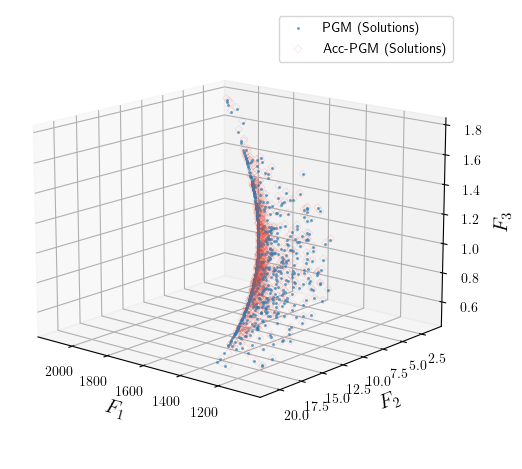

In [33]:
%matplotlib inline
show_Pareto_front(problem_FDS, results_FDS, results_acc_FDS, fname='FDS.pdf')

### Accelerated Proximal Gradient Method (over relaxation) 

In [34]:
results_acc_overrelax_FDS = run(problem_FDS, start_points_FDS, nesterov=True,
                            nesterov_ratio=(0.25, 0.25))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8

CPU times: user 3.25 s, sys: 377 ms, total: 3.62 s
Wall time: 45min 24s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 45.4min finished


### Complexity

In [35]:
stats_overrelax_FDS = {'PGM': get_stats(results_FDS),
         'Acc-PGM (over relax)': get_stats(results_acc_overrelax_FDS)}
pprint.pprint(stats_overrelax_FDS)

{'Acc-PGM (over relax)': {'execusion_time': {'max': 45.99159026145935,
                                             'mean': 21.741364013671873,
                                             'std': 5.48012644804871},
                          'nit': {'max': 406, 'mean': 184.308, 'std': 184.308},
                          'nit_internal': {'max': 15688,
                                           'mean': 7352.678,
                                           'std': 1862.5926383178905}},
 'PGM': {'execusion_time': {'max': 431.58761405944824,
                            'mean': 79.17063086271285,
                            'std': 70.30812084879072},
         'nit': {'max': 3728, 'mean': 639.872, 'std': 639.872},
         'nit_internal': {'max': 138788,
                          'mean': 25344.495,
                          'std': 22808.821461925098}}}


0it [00:00, ?it/s]

CPU times: user 4.24 s, sys: 186 ms, total: 4.43 s
Wall time: 4.22 s


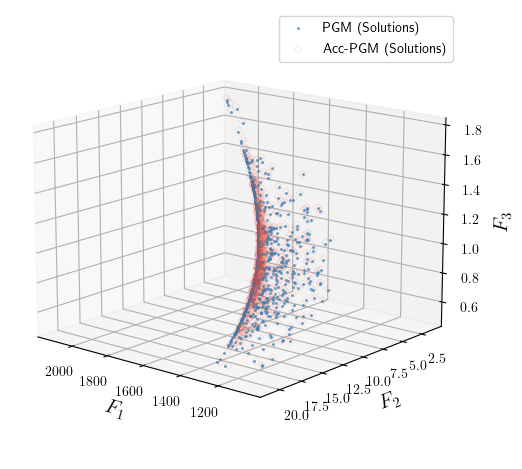

In [36]:
%matplotlib inline
show_Pareto_front(problem_FDS, results_FDS, results_acc_overrelax_FDS)

In [63]:
n_dims = 10
problem_FDS_CONSTRAINED = FDS_CONSTRAINED(n_dims=n_dims)
start_points_FDS_CONSTRAINED = generate_start_points(low=0, high=2, n_dims=n_dims)

CPU times: user 4.4 ms, sys: 1.31 ms, total: 5.71 ms
Wall time: 4.74 ms


In [64]:
results_FDS_CONSTRAINED = run(problem_FDS_CONSTRAINED, start_points_FDS_CONSTRAINED)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/zalgo/.anyenv/envs/pyenv/versions/3.9.9/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.6min
/Users/zalgo/.anyenv/envs/pyenv/versions/3.9.9/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('del

CPU times: user 19.2 s, sys: 1.64 s, total: 20.8 s
Wall time: 5h 19min 20s


In [65]:
results_acc_FDS_CONSTRAINED = run(problem_FDS_CONSTRAINED, start_points_FDS_CONSTRAINED, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13

CPU times: user 9.84 s, sys: 432 ms, total: 10.3 s
Wall time: 1h 16min 58s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 77.0min finished


In [66]:
stats_FDS_CONSTRAINED = {'PGM': get_stats(results_FDS_CONSTRAINED), 'Acc-PGM': get_stats(results_acc_FDS_CONSTRAINED)}
pprint.pprint(stats_FDS_CONSTRAINED)

{'Acc-PGM': {'execusion_time': {'max': 78.36530208587646,
                                'mean': 36.84471138095856,
                                'std': 10.781726392639843},
             'nit': {'max': 519, 'mean': 275.377, 'std': 85.87436678660286},
             'nit_internal': {'max': 20915,
                              'mean': 10973.149,
                              'std': 3195.578341208208}},
 'PGM': {'execusion_time': {'max': 495.6410503387451,
                            'mean': 152.70296910738946,
                            'std': 103.58685304921688},
         'nit': {'max': 3657, 'mean': 1066.212, 'std': 749.3742556666862},
         'nit_internal': {'max': 134604,
                          'mean': 41861.274,
                          'std': 28053.1719391395}}}


0it [00:00, ?it/s]

CPU times: user 18.6 s, sys: 788 ms, total: 19.4 s
Wall time: 19.8 s


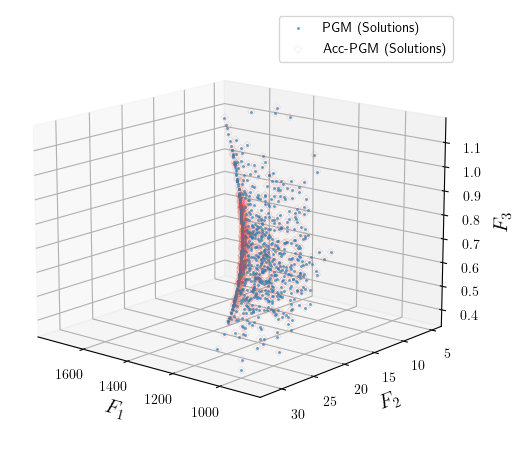

In [67]:
%%time%matplotlib inline
show_Pareto_front(problem_FDS_CONSTRAINED, results_FDS_CONSTRAINED, results_acc_FDS_CONSTRAINED, fname='FDS_CONSTRAINED.pdf')